# Quickstart example for cancer simulation 
This notebook illustrates how to run a 2D cancer simulation using CancerSim. It's a rather contrieved example with no actual scientific background. It's main purpose is to give a simple example to be used as a template for more complex simulation runs. It also demonstrates how to parametrize the simulation through the `CancerSimulationParameters` API instead of the `params.py` module.

The simulation treats a 2D tumour on a 20x20 grid for 10 generations. Healthy cells and cancer cells differ by their division probabilities (0.5 vs 0.8), death probabilities (0.1 vs. 0.4), and mutation probabilities (0.2 vs. 0.8). The first cancer cell carries 2 mutations, new mutations occur with a 20% probability and 10 fold abundance. The first advantageous mutation occurs in the 3rd generation. We sample 10% of the tumour at a read depth of 100.

After the run, we plot the tumour growth curve and the mutation frequency histograms for the whole tumour and the sampled tumour.

## Import modules 

In [6]:
# The cancer simulation module.
from casim import casim
import logging

In [2]:
#  3rd party modules.
import os, shutil
from wand.image import Image as WImage # To render pdf images in nb.
from glob import glob

## Setup parameters 

In [3]:
parameters=casim.CancerSimulatorParameters(
                                matrix_size=20,
                                number_of_generations=10,
                                division_probability=0.5,
                                adv_mutant_division_probability=0.8,
                                death_probability=0.1,
                                adv_mutant_death_probability=0.4,
                                mutation_probability=0.2,
                                adv_mutant_mutation_probability=0.8,
                                number_of_mutations_per_division=10,
                                adv_mutation_wait_time=3,
                                number_of_initial_mutations=2,
                                sampling_fraction=0.1,
                                plot_tumour_growth=True,
                                export_tumour=True
                               )

## Setup the simulation engine. 

In [4]:
if os.path.isdir('out'):
    shutil.rmtree('out')

In [7]:
cancer_sim = casim.CancerSimulator(parameters, seed=1, outdir='out/')

In [11]:
# Get more verbose logging.
logger = logging.getLogger().setLevel("INFO")

## Run the simulation 

In [10]:
cancer_sim.run()

2020-08-10 16:14:45,538 INFO: Running in single tumour mode.
2020-08-10 16:14:45,540 INFO: First cell at (10, 10).
2020-08-10 16:14:45,542 INFO: Ready to start CancerSim run with these parameters:
2020-08-10 16:14:45,543 INFO: matrix_size = 20
2020-08-10 16:14:45,544 INFO: number_of_generations = 10
2020-08-10 16:14:45,545 INFO: division_probability = 0.5
2020-08-10 16:14:45,546 INFO: adv_mutant_division_probability = 0.8
2020-08-10 16:14:45,547 INFO: death_probability = 0.1
2020-08-10 16:14:45,547 INFO: adv_mutant_death_probability = 0.4
2020-08-10 16:14:45,548 INFO: mutation_probability = 0.2
2020-08-10 16:14:45,549 INFO: adv_mutant_mutation_probability = 0.8
2020-08-10 16:14:45,550 INFO: number_of_mutations_per_division = 10
2020-08-10 16:14:45,551 INFO: adv_mutation_wait_time = 3
2020-08-10 16:14:45,551 INFO: number_of_initial_mutations = 2
2020-08-10 16:14:45,552 INFO: tumour_multiplicity = single
2020-08-10 16:14:45,553 INFO: read_depth = 100
2020-08-10 16:14:45,554 INFO: samplin

0

<Figure size 432x288 with 0 Axes>

## Output
After the run has finished, you should find the results in
`out/cancer_1/simOutput`.

In [12]:
!ls out/cancer_1/simOutput

death_list.p	 mtx_VAF.txt		    sample_out_12_11.txt
growthCurve.pdf  mut_container.p	    wholeTumourVAFHistogram.pdf
mtx.p		 sampleHistogram_12_11.pdf


Files with the extension `.p` are binary files (python pickles) needed to
restart a simulation. Let's take a look at the `.txt`  files. They contain the simulation output:
`mtx_VAF.txt` is a datafile with three columns: `mutation_id` lists the index of
each primary mutation, `additional_mut_id` indexes the subsequent mutations that occur in a cell of
a given `mutation_id`; `frequency` is the frequency at which a given mutation occurs.

The file `sample_out_502_488.txt` lists all mutations of the artificial sample
taken from the whole tumour. Columns are identical to `mtx_VAF.txt`.
 
The two `.pdf` files are plots of the whole tumour histogram and the sampled
tumour histogram, respectively. You should see figures similar to these:

## Display results. 
The mutation frequency histogram for the whole tumour and the for sampled part of the tumour, as well as the tumour growth curve (number of tumour cells vs. time) are stored as pdf images in the simulation output directory. 

In [13]:
image_path=os.path.join(cancer_sim.outdir,'cancer_1', 'simOutput')

In [14]:
pdfs = glob(os.path.join(image_path,"*.pdf"))

In [15]:
pdfs

['out/cancer_1/simOutput/growthCurve.pdf',
 'out/cancer_1/simOutput/sampleHistogram_12_11.pdf',
 'out/cancer_1/simOutput/wholeTumourVAFHistogram.pdf']

out/cancer_1/simOutput/growthCurve.pdf


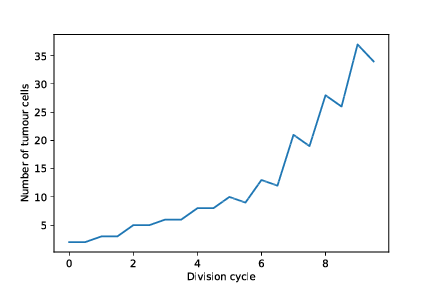

out/cancer_1/simOutput/sampleHistogram_12_11.pdf


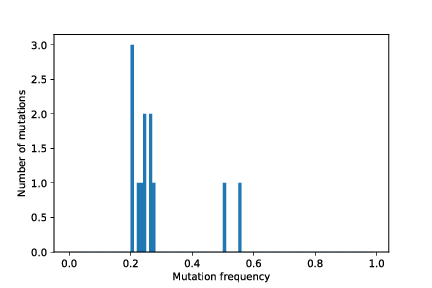

out/cancer_1/simOutput/wholeTumourVAFHistogram.pdf


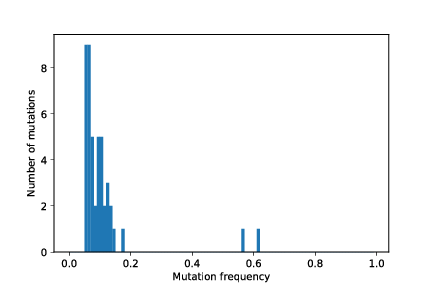

In [16]:
for pdf in pdfs:
    print(pdf)
    display(WImage(filename=pdf))

### Load binary files (pickles)
The remaining output files are serialized versions ("pickles") of the tumour
geometry as a 2D matrix (`mtx.p`), the death list (`death_list.p`), and the
mutation list (list of tuples listing the parent and the mutation ID of each
tumour cell, `mut_container.p`).

To read the pickled data, we define a utility function

In [17]:
import pickle
from matplotlib import pyplot

In [18]:
def unpickle(file):

    with open(os.path.join(cancer_sim._CancerSimulator__simdir, file),'rb') as fp:
        return pickle.load(fp)

In [19]:
# Load the mutation matrix
mtx=unpickle('mtx.p').toarray()

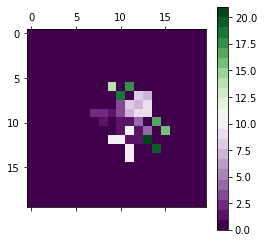

In [20]:
# Plot the tumour as a 2D map color coding the mutation ID
cmap = pyplot.cm.get_cmap('PRGn', mtx.max()+1)

pyplot.matshow(mtx, cmap=cmap)
pyplot.colorbar()

In [21]:
unpickle('mut_container.p')

[(0, 0),
 (0, 1),
 (1, 2),
 (1, 3),
 (1, 4),
 (1, 5),
 (5, 6),
 (5, 7),
 (6, 8),
 (6, 9),
 (1, 10),
 (1, 11),
 (3, 12),
 (3, 13),
 (3, 14),
 (3, 15),
 (4, 16),
 (4, 17),
 (15, 18),
 (15, 19),
 (1, 20),
 (1, 21)]